# Titanic Kaggle by Jordan Ziskin

## Task

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we are tasked with building a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc). 

In [1]:
# Imports
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

## Exploratory Data Analysis

Let's start by reading in the data and looking at its dimensions and summary.

In [2]:
# Read in data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.name = "Train"
test.name = "Test"

In [3]:
# View Dimensions
print(f'Training data has {train.shape[0]} rows and {train.shape[1]} rows')
print(f'Testing data has {test.shape[0]} rows and {test.shape[1]} rows')

Training data has 891 rows and 12 rows
Testing data has 418 rows and 11 rows


In [4]:
# View Head
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [6]:
# Assign ID to variables and remove from dataset
id_train = train.pop("PassengerId") 
id_test = test.pop("PassengerId") 

Our training dataset consists of 891 observations, and 12 columns. Of the 12 columns, 1 is the PassengerID, 1 is the response variable "Survived", and the remaining 10 are predictors. The testing dataset has 418 observations with 11 columns. The missing column from the testing dataset is, of course, the response variable "Survived" which we will be predicting here. The ID column was removed from the training and testing datasets and stored as pandas series. Let's look at each column individually and see what we can learn.

In [7]:
# Calculate survival rate
n_passengers_train = len(train)
n_survived = sum(train["Survived"]==1)
n_died = sum(train["Survived"]==0)
print(f'Of all {n_passengers_train} passengers in the training data, {n_survived} survived and {n_died} died.')
print(f'Survival Rate: {round(100*n_survived/len(train),2)}%')

Of all 891 passengers in the training data, 342 survived and 549 died.
Survival Rate: 38.38%


Only about 38% of all passengers in the training set survived. Let's look at each predictor variable and determine how the survival rate is affected when we separate our passengers by their attributes. To help us visualize this, we'll write a function survival_plot which will create a bar plot of the suvival rates based on different features. We'll also write a function missing_vals that prints the number of missing values in a column for both the training and testing datasets.

In [8]:
def survival_plot(feature, label="Survived", df=train, bins=[]):
    """Produces a plot of survival rate given column in training data"""
    # Create bins if necessary
    if bins:
        df = pd.DataFrame({feature:pd.cut(df[feature], bins=bins), label:df[label]})
    
    # Extract Data
    plot_labels = sorted(df[feature].dropna().unique())
    survival_rate = [100*val for val in df.groupby([feature]).mean()[label]]
    death_rate = [100*(1-val) for val in df.groupby([feature]).mean()[label]]
        
    # Create plot
    fig = plt.figure()
    locs = np.arange(len(plot_labels))
    width = 0.35 # bar width
    ax = fig.add_axes([0,0,2,1])
    rects1 = ax.bar(locs - width/2, survival_rate, width, label='Survived', color = 'g')
    rects2 = ax.bar(locs + width/2, death_rate, width, label='Died', color = 'r')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel(feature)
    ax.set_ylabel('Rate as a %')
    ax.set_title(f'Passenger Survival Rate by {feature.title()}')
    ax.set_xticks(locs)
    ax.set_xticklabels(plot_labels)
    ax.legend()
    plt.show()
    
def missing_vals(col):
    print(f'The training data has {sum(train[col].isna())} missing {col.lower()} values.')
    print(f'The testing data has {sum(test[col].isna())} missing {col.lower()} values.')

## Feature Exploration

### Pclass

Let's see how different Pclass values affect the survival rate.

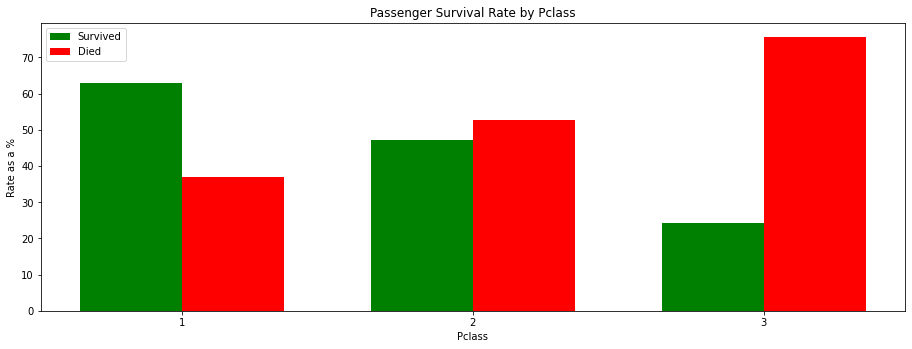

In [9]:
survival_plot("Pclass")

In [10]:
missing_vals("Pclass")

The training data has 0 missing pclass values.
The testing data has 0 missing pclass values.


We can clearly see that Pclass is indirectly correlated with survival. For that reason, it seems wise to include Pclass as a predictor in our model and keep it as a continuous variable. Next we’ll look at Sex.

### Sex

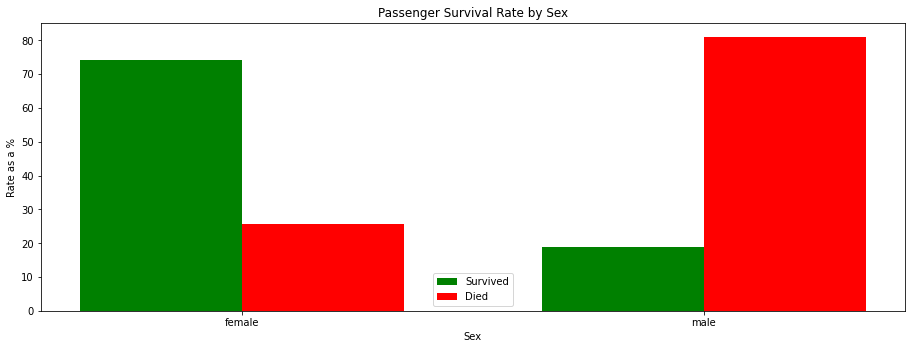

In [11]:
survival_plot("Sex")

In [12]:
missing_vals("Sex")

The training data has 0 missing sex values.
The testing data has 0 missing sex values.


As expected, the survival rate of females is significantly larger than the survival rate of males. This suggests that sex is going to be a very strong indicator in determining survival.

### Age

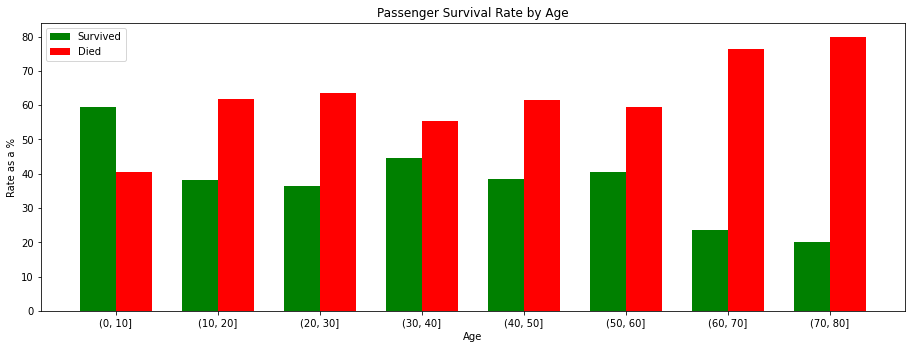

In [13]:
survival_plot("Age", bins=range(0, 90, 10))

In [14]:
missing_vals("Age")

The training data has 177 missing age values.
The testing data has 86 missing age values.


Looking at the survival rate by age, we can see that as age increase, the survival rate tends to decrease. While age may not be the strongest indicator, I expect it will still be helpful when combined with the other predictors. Unfortunately, we have a lot of missing values in both the training and testing datasets. We will use data imputation strategies to best predict these missing values a little later. 

### Sibsp & Parch

Next we’ll look at the variables Sibsp and Parch. The distinction between these two categories seem somewhat arbitrary. Why would the numbers of siblings and spouse be together in one category while parents and children be together in another category. It may be helpful to combine these variables into one variable called FamSize for family size. Let’s look more closely at this combined family size variable.

In [15]:
missing_vals("SibSp")
missing_vals("Parch")

The training data has 0 missing sibsp values.
The testing data has 0 missing sibsp values.
The training data has 0 missing parch values.
The testing data has 0 missing parch values.


In [16]:
for df in [train, test]:
    df["nFamSize"] = df["SibSp"] + df["Parch"]
    df.pop("SibSp")
    df.pop("Parch")

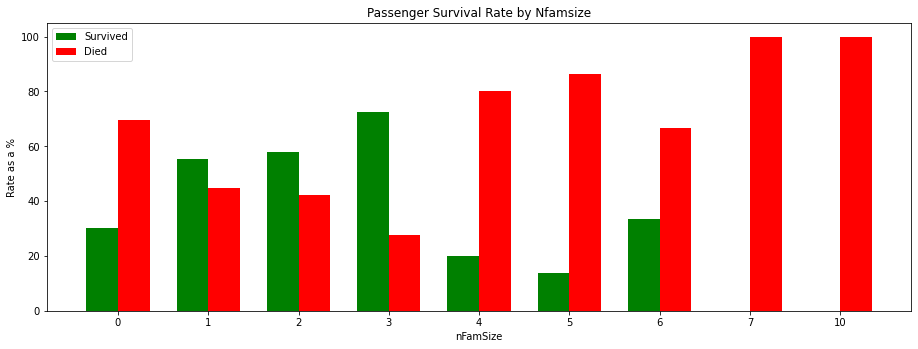

In [17]:
survival_plot("nFamSize")

There seems to be a somewhat quadratic relationship between survival rate and family size with very large and very small family sizes incurring the greatest number of deaths. For this reason it may be more helpful to make FamSize a categorical variable with 3 categories, “Solo” (FamSize=0), “Nuclear” (FamSize=1-3) and “Large” (FamSize > 3).

In [18]:
for df in [train, test]:
    df.loc[df["nFamSize"]==0, "FamSize"] = "Solo"
    df.loc[(df["nFamSize"]>=1) & (df["nFamSize"]<=3), "FamSize"] = "Nuclear"
    df.loc[df["nFamSize"]>3, "FamSize"] = "Large"
    df.pop("nFamSize")

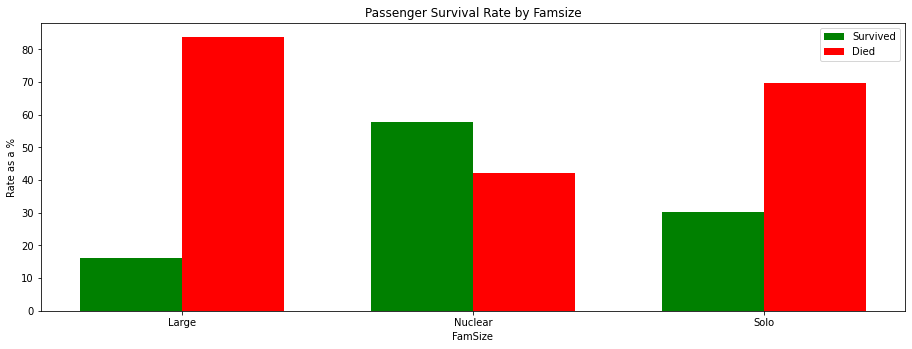

In [19]:
survival_plot("FamSize")

### Embarked

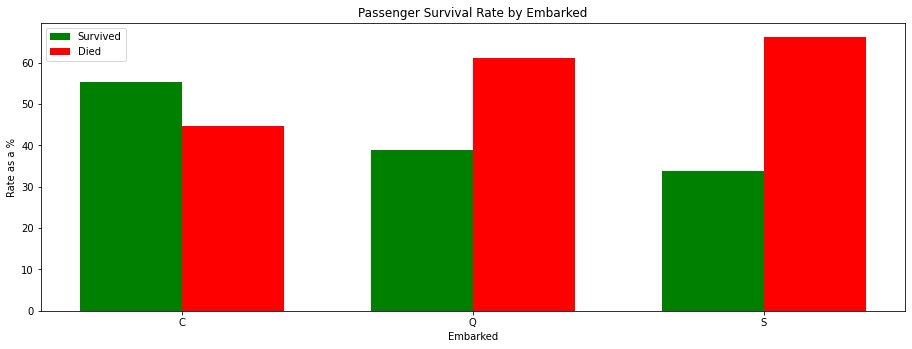

In [20]:
survival_plot("Embarked")

In [21]:
missing_vals("Embarked")

The training data has 2 missing embarked values.
The testing data has 0 missing embarked values.


Passengers who embarked from location C seems to have a net positive survival rate, while those who embarked from locations Q and S have a net negative survival rate. We should also note that we have 2 missing embarked values in the training set. We'll consider how to deal with those later in our analysis. Next, let’s look at the Cabin column.

### Cabin

Let's start by looking at all the different cabin entries.

In [22]:
sorted(train["Cabin"].dropna().unique())

['A10',
 'A14',
 'A16',
 'A19',
 'A20',
 'A23',
 'A24',
 'A26',
 'A31',
 'A32',
 'A34',
 'A36',
 'A5',
 'A6',
 'A7',
 'B101',
 'B102',
 'B18',
 'B19',
 'B20',
 'B22',
 'B28',
 'B3',
 'B30',
 'B35',
 'B37',
 'B38',
 'B39',
 'B4',
 'B41',
 'B42',
 'B49',
 'B5',
 'B50',
 'B51 B53 B55',
 'B57 B59 B63 B66',
 'B58 B60',
 'B69',
 'B71',
 'B73',
 'B77',
 'B78',
 'B79',
 'B80',
 'B82 B84',
 'B86',
 'B94',
 'B96 B98',
 'C101',
 'C103',
 'C104',
 'C106',
 'C110',
 'C111',
 'C118',
 'C123',
 'C124',
 'C125',
 'C126',
 'C128',
 'C148',
 'C2',
 'C22 C26',
 'C23 C25 C27',
 'C30',
 'C32',
 'C45',
 'C46',
 'C47',
 'C49',
 'C50',
 'C52',
 'C54',
 'C62 C64',
 'C65',
 'C68',
 'C7',
 'C70',
 'C78',
 'C82',
 'C83',
 'C85',
 'C86',
 'C87',
 'C90',
 'C91',
 'C92',
 'C93',
 'C95',
 'C99',
 'D',
 'D10 D12',
 'D11',
 'D15',
 'D17',
 'D19',
 'D20',
 'D21',
 'D26',
 'D28',
 'D30',
 'D33',
 'D35',
 'D36',
 'D37',
 'D45',
 'D46',
 'D47',
 'D48',
 'D49',
 'D50',
 'D56',
 'D6',
 'D7',
 'D9',
 'E10',
 'E101',
 'E12',
 

In [23]:
sorted(test["Cabin"].dropna().unique())

['A11',
 'A18',
 'A21',
 'A29',
 'A34',
 'A9',
 'B10',
 'B11',
 'B24',
 'B26',
 'B36',
 'B41',
 'B45',
 'B51 B53 B55',
 'B52 B54 B56',
 'B57 B59 B63 B66',
 'B58 B60',
 'B61',
 'B69',
 'B71',
 'B78',
 'C101',
 'C105',
 'C106',
 'C116',
 'C130',
 'C132',
 'C22 C26',
 'C23 C25 C27',
 'C28',
 'C31',
 'C32',
 'C39',
 'C46',
 'C51',
 'C53',
 'C54',
 'C55 C57',
 'C6',
 'C62 C64',
 'C7',
 'C78',
 'C80',
 'C85',
 'C86',
 'C89',
 'C97',
 'D',
 'D10 D12',
 'D15',
 'D19',
 'D21',
 'D22',
 'D28',
 'D30',
 'D34',
 'D37',
 'D38',
 'D40',
 'D43',
 'E31',
 'E34',
 'E39 E41',
 'E45',
 'E46',
 'E50',
 'E52',
 'E60',
 'F',
 'F E46',
 'F E57',
 'F G63',
 'F2',
 'F33',
 'F4',
 'G6']

In [24]:
missing_vals("Cabin")

The training data has 687 missing cabin values.
The testing data has 327 missing cabin values.


We notice a few things looking at the Cabin column.

1. Most people do not have a cabin listed.
2. Cabin names are typically a letter A-G, followed by a number
3. Some entries have more than 1 cabin listed.
4. Some entries have a letter listed and then a cabin with another letter like “F G73”, “F E57”, and “F E69”
5. In the training dataset we have one cabin listed as “T”

How we deal with these findings is going to take some judgment. Because the vast majority of cabins are missing, we have to concede that it is very unlikely that we will have enough information to predict the cabin of the missing entries. So with that said, we should first consider if there is any difference between the entries for which cabin is named and cabin isn’t named. If there is no difference, it may be worth throwing out the column entirely.


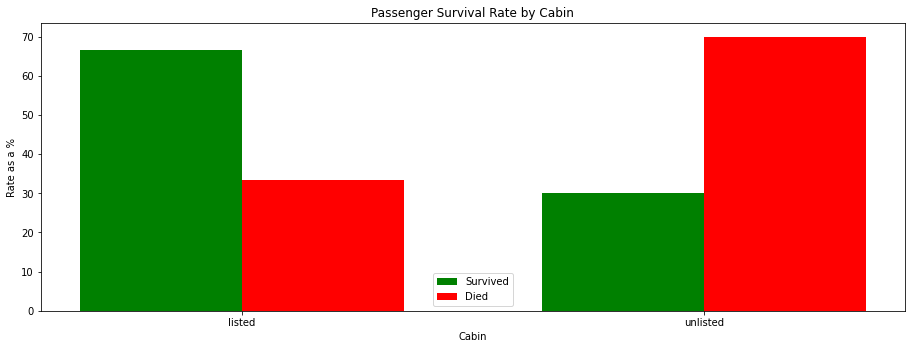

In [25]:
df = pd.DataFrame({"Cabin":["unlisted" if x else "listed" for x in train["Cabin"].isna()], 
                   "Survived":train["Survived"]})
survival_plot("Cabin", df=df)

We can see that for the entries for which the cabin is listed, the survival rate was significantly higher. This could be due to survivor bias; those who survived the titanic were able to live to tell their cabin number. Or perhaps there is another reason. Regardless, it seems there is merit to keeping this variable. Let’s try to break cabin down even more by using the first letter of the cabin number. Above, we noticed that there were a handful of entries that had the letter F followed by a space and then another non-F cabin like “F G73”, “F E57”, and “F E69.” Below we will list these entries and then we’ll remove the F and the space.

In [26]:
train.loc[train['Cabin'].str.contains(r'^F ', flags=re.I, regex=True, na=False)]

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamSize
75,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,348123,7.6500,F G73,S,Solo
128,1,3,"Peter, Miss. Anna",female,NaN,2668,22.3583,F E69,C,Nuclear
699,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,348121,7.6500,F G63,S,Solo
715,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,348124,7.6500,F G73,S,Solo


In [27]:
test.loc[test['Cabin'].str.contains(r'^F ', flags=re.I, regex=True, na=False)]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamSize
57,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,348122,7.6500,F G63,S,Solo
288,3,"Mardirosian, Mr. Sarkis",male,NaN,2655,7.2292,F E46,C,Solo
321,3,"Krekorian, Mr. Neshan",male,25.0,2654,7.2292,F E57,C,Solo


In [28]:
# Remove F and space characters from multi-lettered cabin entries
for df in  [train, test]:
    trimmed = df.loc[df['Cabin'].str.contains(
        r'^F ', flags=re.I, regex=True, na=False)].Cabin.apply(lambda x: x[2:])
    for idx, val in trimmed.items():
        df.loc[idx, "Cabin"] = val

In [29]:
# View Changed Rows
train.loc[[75, 128, 699, 715], :]

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamSize
75,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,348123,7.6500,G73,S,Solo
128,1,3,"Peter, Miss. Anna",female,NaN,2668,22.3583,E69,C,Nuclear
699,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,348121,7.6500,G63,S,Solo
715,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,348124,7.6500,G73,S,Solo


In [30]:
# View Changed Rows
test.loc[[57, 288, 321], :]

,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamSize
57,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,348122,7.6500,G63,S,Solo
288,3,"Mardirosian, Mr. Sarkis",male,NaN,2655,7.2292,E46,C,Solo
321,3,"Krekorian, Mr. Neshan",male,25.0,2654,7.2292,E57,C,Solo


Additionally, let’s replace the cabin marked “T” with NA.

In [31]:
train.loc[train['Cabin']=="T", :]

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamSize
339,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,113784,35.5,T,S,Solo


In [32]:
train.loc[train['Cabin']=="T", "Cabin"] = np.NaN

Now that every cabin entry is either NA or begins with a letter A-G, we will create a new row called CabinLetter which takes the first letter of the cabin.

In [33]:
for df in [train, test]:
    df["CabinLetter"] = df["Cabin"].apply(lambda x: x[0] if not pd.isna(x) else np.NaN)

Lets also replace all missing cabin values with "Unknown" because as we saw earlier, if we don't have the cabin information, this tells us it is more likely the person died.

In [34]:
for df in [train, test]:
    df["CabinLetter"] = df["CabinLetter"].fillna("Unknown")

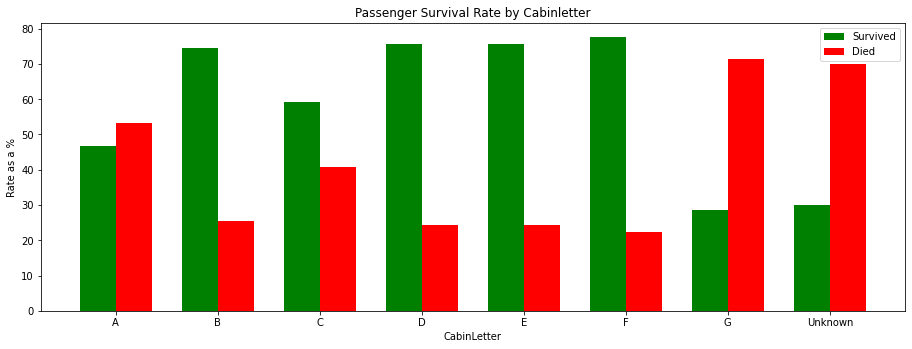

In [35]:
survival_plot("CabinLetter")

Because only certain cabin letters, B-F, produce a net positive survival rate, it is helpful to have these separate categories as opposed to the previous version of cabin being listed vs. unlisted. In the CabinLetter column, we have replaced all NAs with “Unknown.” Before we move on to the next category, we should look for any relationship between cabin number and survival. Perhaps passengers with rooms towards the middle or one particular side of the ship had a lower great of survival than everyone else.

In [36]:
for df in [train, test]:
    df["CabinNumber"] = df["Cabin"].apply(lambda x: np.NaN if pd.isna(x) else x.split(' ')[0][1:])
    df["CabinNumber"] = df["CabinNumber"].replace("", np.NaN)
    df["CabinNumber"] = df["CabinNumber"].apply(float)

In [37]:
sorted(train["CabinNumber"].dropna().apply(int).unique())

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 54,
 56,
 57,
 58,
 62,
 63,
 65,
 67,
 68,
 69,
 70,
 71,
 73,
 77,
 78,
 79,
 80,
 82,
 83,
 85,
 86,
 87,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 99,
 101,
 102,
 103,
 104,
 106,
 110,
 111,
 118,
 121,
 123,
 124,
 125,
 126,
 128,
 148]

In [38]:
sorted(test["CabinNumber"].dropna().apply(int).unique())

[2,
 4,
 6,
 7,
 9,
 10,
 11,
 15,
 18,
 19,
 21,
 22,
 23,
 24,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 45,
 46,
 50,
 51,
 52,
 53,
 54,
 55,
 57,
 58,
 60,
 61,
 62,
 63,
 69,
 71,
 78,
 80,
 85,
 86,
 89,
 97,
 101,
 105,
 106,
 116,
 130,
 132]

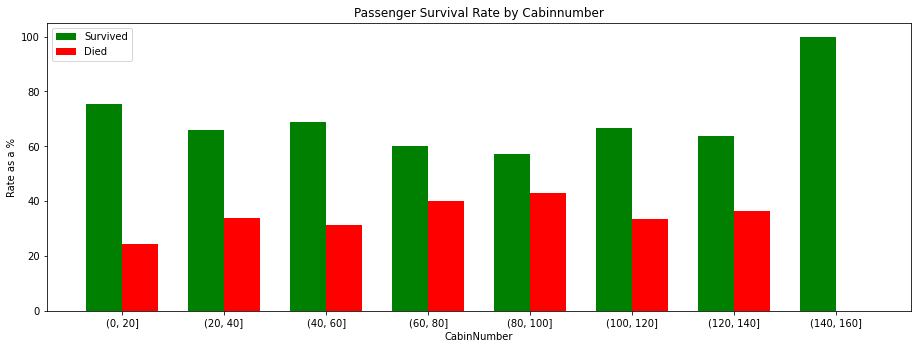

In [39]:
survival_plot("CabinNumber", bins=range(0, 180, 20))

There doesn’t seem to be any strong relationship between cabin number and survival rate. The only thing we can deduce is that entries that had cabin numbers were more likely to survive than not. We could potentially create a boolean feature that keeps track of whether or not a cabin number was listed, but this information is already likely captured in the CabinLetter feature. As a result, we’ll remove this variable as well as Cabin.

In [40]:
for df in [train, test]:
    df.pop("Cabin")
    df.pop("CabinNumber")

### Fare

Let’s see if there is any correlation between fare and survival rate.

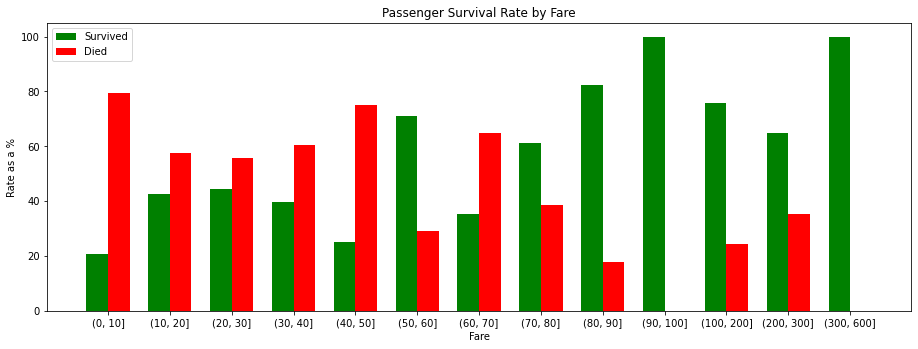

In [41]:
survival_plot("Fare", bins=[10*x for x in range(11)]+[200, 300, 600])

As expected, we can see a clear relationship between fare and survival rate. The rich were able to use their influence to get on lifeboats, while many of the poor perished. Let's keep this in our model. Next, we’ll see if there is anything we can find from the ticket column.

### Ticket

In [42]:
sorted(train["Ticket"].unique())

['110152',
 '110413',
 '110465',
 '110564',
 '110813',
 '111240',
 '111320',
 '111361',
 '111369',
 '111426',
 '111427',
 '111428',
 '112050',
 '112052',
 '112053',
 '112058',
 '112059',
 '112277',
 '112379',
 '113028',
 '113043',
 '113050',
 '113051',
 '113055',
 '113056',
 '113059',
 '113501',
 '113503',
 '113505',
 '113509',
 '113510',
 '113514',
 '113572',
 '113760',
 '113767',
 '113773',
 '113776',
 '113781',
 '113783',
 '113784',
 '113786',
 '113787',
 '113788',
 '113789',
 '113792',
 '113794',
 '113796',
 '113798',
 '113800',
 '113803',
 '113804',
 '113806',
 '113807',
 '11668',
 '11751',
 '11752',
 '11753',
 '11755',
 '11765',
 '11767',
 '11769',
 '11771',
 '11774',
 '11813',
 '11967',
 '12233',
 '12460',
 '12749',
 '13049',
 '13213',
 '13214',
 '13502',
 '13507',
 '13509',
 '13567',
 '13568',
 '14311',
 '14312',
 '14313',
 '14973',
 '1601',
 '16966',
 '16988',
 '17421',
 '17453',
 '17463',
 '17464',
 '17465',
 '17466',
 '17474',
 '17764',
 '19877',
 '19928',
 '19943',
 '19947'

In [43]:
sorted(test["Ticket"].unique())

['110469',
 '110489',
 '110813',
 '111163',
 '112051',
 '112058',
 '112377',
 '112378',
 '112901',
 '113038',
 '113044',
 '113054',
 '113059',
 '113503',
 '113509',
 '113773',
 '113778',
 '113780',
 '113781',
 '113790',
 '113791',
 '113795',
 '113796',
 '113801',
 '11753',
 '11765',
 '11767',
 '11769',
 '11770',
 '11778',
 '11813',
 '1222',
 '12749',
 '13050',
 '13236',
 '13508',
 '13567',
 '13695',
 '13905',
 '1601',
 '16966',
 '17463',
 '17464',
 '17475',
 '17765',
 '17770',
 '19877',
 '19924',
 '19928',
 '19950',
 '2003',
 '211535',
 '21228',
 '21332',
 '220844',
 '220845',
 '226875',
 '228414',
 '230136',
 '233478',
 '233734',
 '235509',
 '236853',
 '236854',
 '237216',
 '237249',
 '237393',
 '237670',
 '237734',
 '237735',
 '237789',
 '239059',
 '240261',
 '240276',
 '24065',
 '24160',
 '242963',
 '244346',
 '244358',
 '244360',
 '244368',
 '248659',
 '248726',
 '248734',
 '248738',
 '248744',
 '248746',
 '250650',
 '250651',
 '2543',
 '2621',
 '2622',
 '2625',
 '26360',
 '2650',


Looking at the ticket column there is quite a bit to consider here. Many tickets are either a number of a combination of letters and numbers. For the purposes of this exercise, we will see if there is a relationship between the number of characters on the ticket and survival rate.

In [44]:
for df in [train, test]:
    df["TicketLength"] = df["Ticket"].apply(lambda x: 0 if pd.isna(x) else len(x))

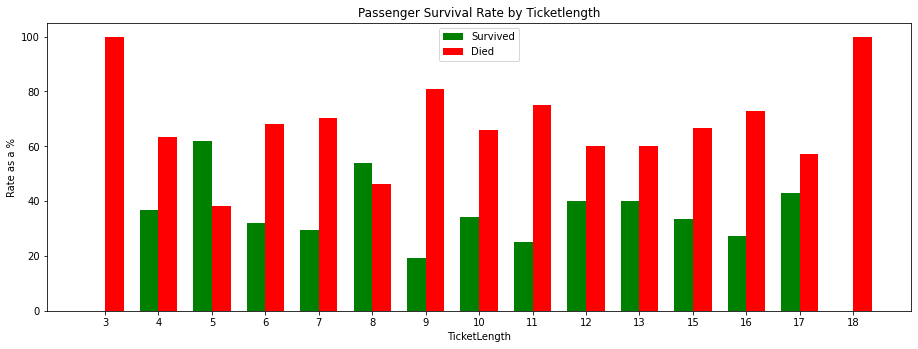

In [45]:
survival_plot("TicketLength")

There does not appear to be any clear relationship between the number of characters in the ticket and the survival rate. Let's instead consider the leading character.

In [46]:
for df in [train, test]:
    df["TicketLetter"] = df["Ticket"].apply(lambda x: x[0] if x[0] not in [str(i) for i in range(10)] else "None")

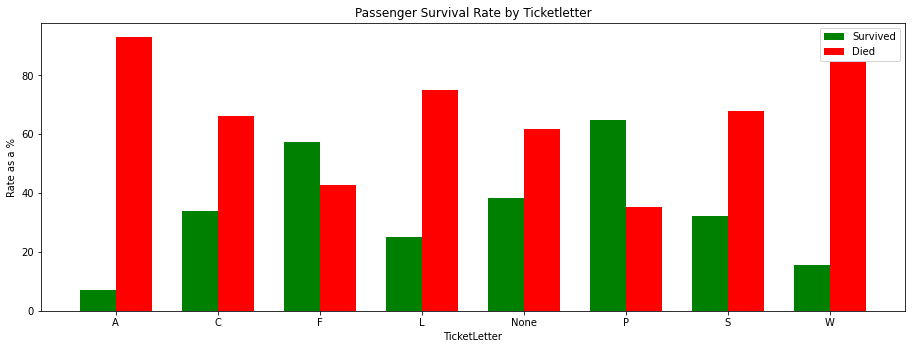

In [47]:
survival_plot("TicketLetter")

We can deduce some information from the ticket letter. It appears those whose ticket begins with "A" and "W" are likely to have died while "F" and "P" indicate people who lived. Before we choose to keep ticket letter, let's look at the value counts.

In [48]:
train["TicketLetter"].value_counts()

None    661
S        65
P        65
C        47
A        29
W        13
F         7
L         4
Name: TicketLetter, dtype: int64

The vast majority of ticket holders have no ticket letter. Additionally, those with ticket letters "S" and "C" have survival rates similar to those without a ticket letter. While a ticket letter of "A" and "W" seem to indicate the person was more likely to die, the low sample sizes for these letters may not make this information particularly useful. That said, 65 people had letter "P" and of those, over 60% survived. Because this information is still useful, we're going to change the column to a binary predictory called "Ticket_P" which simply states whether a ticket begun with "P."

In [49]:
for df in [train, test]:
    df["Ticket_P"] = df["TicketLetter"].apply(lambda x: x == "P")
    df.pop("TicketLetter")
    df.pop("TicketLength")

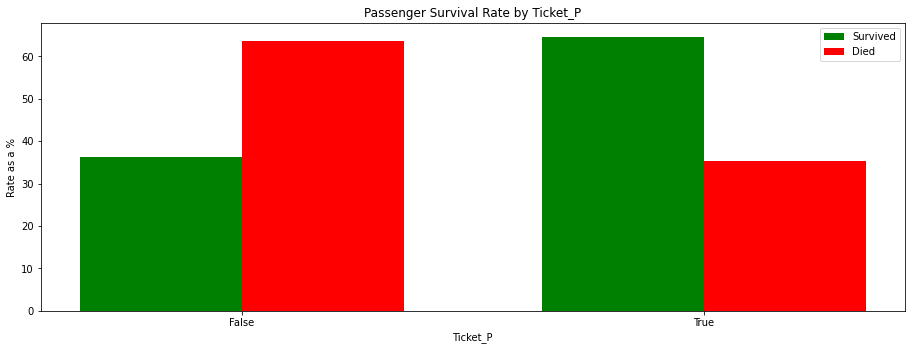

In [50]:
survival_plot("Ticket_P")

In [51]:
for df in [train, test]:
    df["Ticket_P"] = df["Ticket_P"].apply(int)

Let's also consider the first character of the ticket number.

In [52]:
def find_first_number_character(string):
    """Returns first numerical character in string or returns 'None' string"""
    for char in string:
        if char in [str(x) for x in range(10)]:
            return char
    return "None"

for df in [train, test]:
    df["TicketNumber"] = df["Ticket"].apply(find_first_number_character)

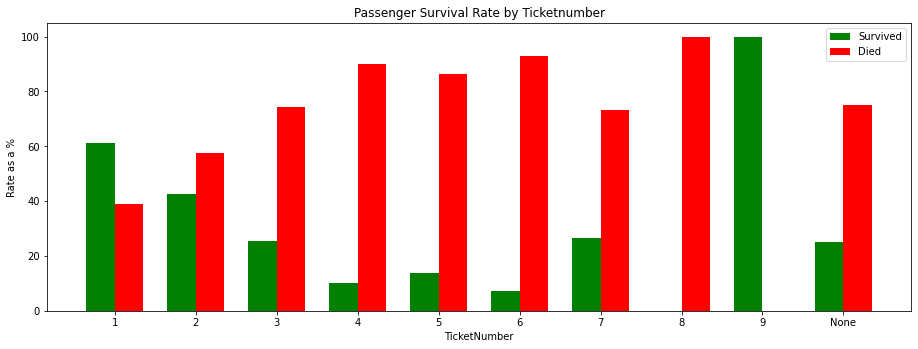

In [53]:
survival_plot("TicketNumber")

Ticket Number seems quite helpful at predicting however, we should make sure that each bin has a large enough sample size to warrent being their own group.

In [54]:
train["TicketNumber"].value_counts()

3       337
2       240
1       227
5        29
4        20
7        15
6        14
None      4
9         3
8         2
Name: TicketNumber, dtype: int64

Since there are so few tickets that either don't have a number or start with 4 - 9, we will group these together as "Other."

In [55]:
for df in [train, test]:
    df["TicketNumber"] = df["TicketNumber"].apply(lambda x: x if x not in [str(x) for x in range(4, 10)] + ["None"] else "Other")

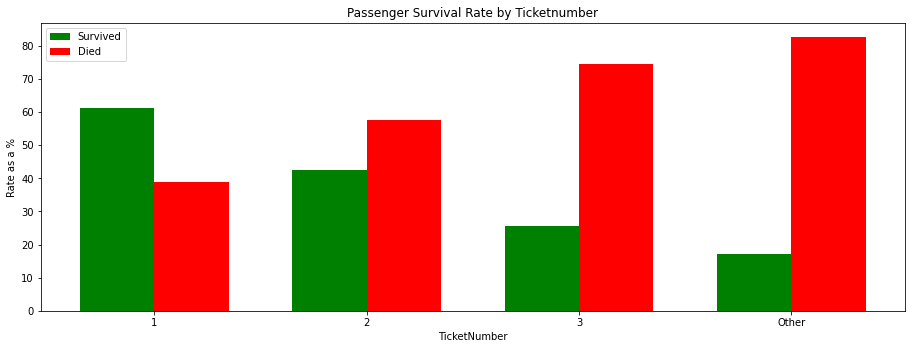

In [56]:
survival_plot("TicketNumber")

And finally, before we move on to looking at passenger names, let's remove the ticket column.

In [57]:
for df in [train, test]:
    df.pop("Ticket")

### Name

Let's start by viewing all the names and searching for patterns that may be useful to us.

In [58]:
train["Name"].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

I noticed that almost all of the passengers are given a title before their name. This title may be useful in determining survival. Let's extract these titles and view the survival plot.

In [59]:
def find_title(string):
    split_name = string.split(",")[-1]
    title = ""
    for char in split_name:
        if char == " ":
            continue
        title+= char
        if char == ".":
            break
    return title
        
for df in [train, test]:
    df["Title"] = df["Name"].apply(find_title)

In [60]:
train["Title"].value_counts()

Mr.             517
Miss.           182
Mrs.            125
Master.          40
Dr.               7
Rev.              6
Major.            2
Col.              2
Mlle.             2
Jonkheer.         1
Ms.               1
theCountess.      1
Sir.              1
Lady.             1
Capt.             1
Don.              1
Mme.              1
Name: Title, dtype: int64

Of the titles, only Mr, Miss, Mrs, and Master have at least 40 observations. Let's group the remaining titles into an other category.

In [61]:
for df in [train, test]:
    df["Title"] = df["Title"].apply(lambda x: x if x in ["Mr.", "Miss.", "Mrs.", "Master."] else "Other")
    df.pop("Name")

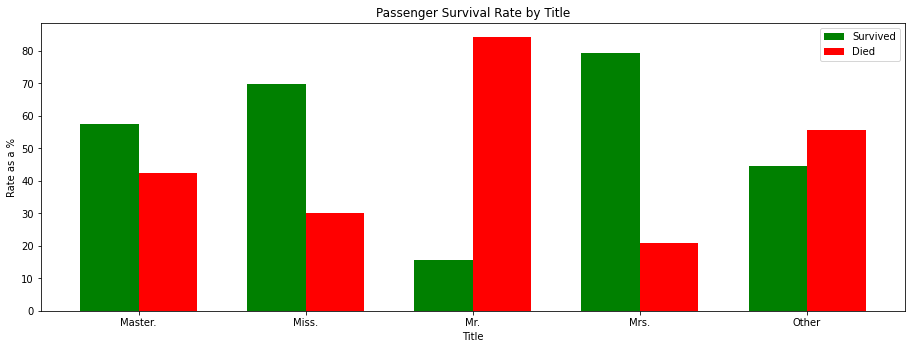

In [62]:
survival_plot("Title")

We can see that title is quite a strong indicator of survival. Now that we've viewed each feature and removed or adjusted them as we saw fit, let's move on to data imputation.

## Data Imputation

As we saw earlier, we have a handful of missing values to deal with. Below, we will locate this missing values and perform imputation where applicable.

In [63]:
def check_for_nas(dfs=[train, test]):
    nas = False
    for df in dfs:
        for col in df:
            if any(df[col].apply(pd.isna)):
                nas = True
                print(f"In the {df.name}ing set, there are {sum(df[col].apply(pd.isna))} missing values in the {col} column")
    if not nas:
        print("There are no missing values")
        
check_for_nas()

In the Training set, there are 177 missing values in the Age column
In the Training set, there are 2 missing values in the Embarked column
In the Testing set, there are 86 missing values in the Age column
In the Testing set, there are 1 missing values in the Fare column


The majority of our missing values are in the Age column. While we have just 3 in the Embarked and Fare columns of the training and testing set, respectively. Because there are so few missing values for Fare and Embarked, let's replace impute them using the average Fare and the most frequent Embarked location.

In [64]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [65]:
train["Fare"].mean()

32.204207968574636

In [66]:
train.loc[pd.isna(train["Embarked"]), "Embarked"] = "S"
test.loc[pd.isna(test["Fare"]), "Fare"] = round(train["Fare"].mean(), 2)

Before we move on, let's check that these values were filled.

In [67]:
check_for_nas()

In the Training set, there are 177 missing values in the Age column
In the Testing set, there are 86 missing values in the Age column


For Age, we are going to have a take a more complex route. My first instinct is to see how age correlates to the other predictors. My hunch is that title and Pclass will be strong indicators of age.

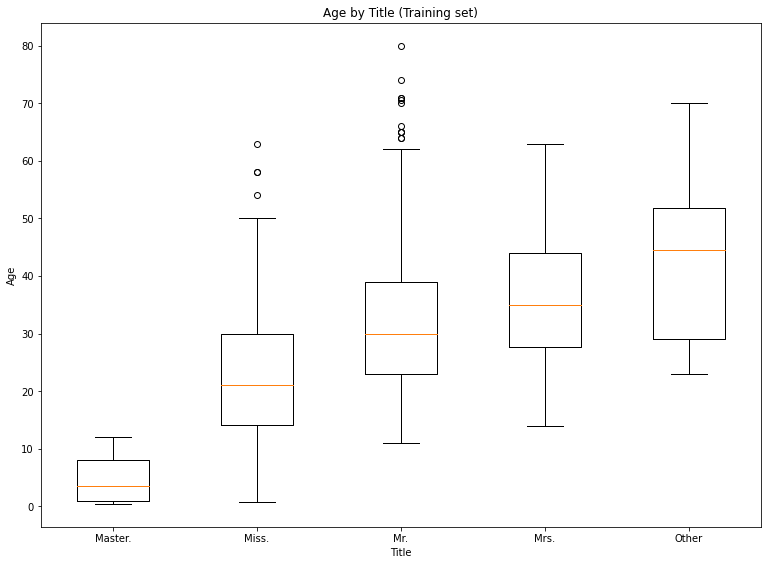

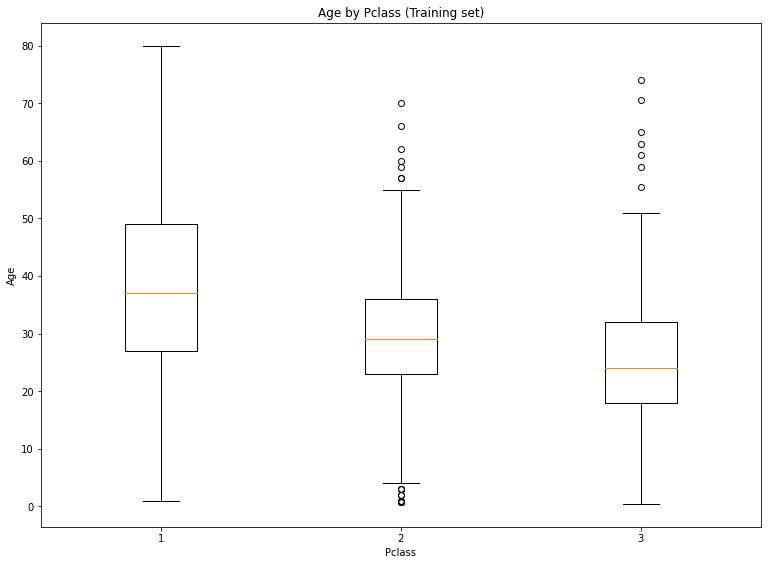

In [68]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

def plot_age_by_feature(df, feature, categories):
    ages = [np.array(df.loc[df[feature] == category, "Age"].dropna()) for category in categories]
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(ages)
    ax.set_xticklabels(categories)
    plt.title(f"Age by {feature.title()} ({df.name}ing set)")
    plt.xlabel(feature.title())
    plt.ylabel("Age")
    plt.show()
    
    
plot_age_by_feature(train, "Title", ["Master.", "Miss.", "Mr.", "Mrs.", "Other"])
plot_age_by_feature(train, "Pclass", range(1, 4))

It appears that title seems to be a strong indicator of a person's age. Particularly, those with the title of master and miss appear to be younger than those with other titles. While Pclass isn't as strong of an indicator, we clearly see that on average older people are in pclass 1 while younger passengers are in pclasses 2 and 3. Therefore we will impute each missing age with the mean age of all passengers containing the same title and belonging to the same pclass.

In [69]:
ages = train.groupby(['Title', 'Pclass'])['Age'].agg('mean').round()
ages

Title    Pclass
Master.  1          5.0
         2          2.0
         3          5.0
Miss.    1         30.0
         2         22.0
         3         16.0
Mr.      1         42.0
         2         33.0
         3         29.0
Mrs.     1         41.0
         2         34.0
         3         34.0
Other    1         43.0
         2         40.0
Name: Age, dtype: float64

In [70]:
meanAgeTrain = train.groupby(['Title', 'Pclass'])['Age'].transform('mean')
    
for df in [train, test]:
    df['Age'] = df['Age'].fillna(meanAgeTrain)

Let's check one more time that we have no more missing values.

In [71]:
check_for_nas()

There are no missing values


## Modeling and Final Prediction

Now that we have taken care of our missing data, let's begin building and testing models. Because we are looking at a classification problem, let's try three of the most popular classifiers, logistic regression random forest, and linear discriminant analysis. Before we model, let's take a look at the dataframes one more time.

In [72]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamSize,CabinLetter,Ticket_P,TicketNumber,Title
0,0,3,male,22.0,7.2500,S,Nuclear,Unknown,0,Other,Mr.
1,1,1,female,38.0,71.2833,C,Nuclear,C,1,1,Mrs.
2,1,3,female,26.0,7.9250,S,Solo,Unknown,0,2,Miss.
3,1,1,female,35.0,53.1000,S,Nuclear,C,0,1,Mrs.
4,0,3,male,35.0,8.0500,S,Solo,Unknown,0,3,Mr.


In [73]:
test.head()

,Pclass,Sex,Age,Fare,Embarked,FamSize,CabinLetter,Ticket_P,TicketNumber,Title
0,3,male,34.5,7.8292,Q,Solo,Unknown,0,3,Mr.
1,3,female,47.0,7.0000,S,Nuclear,Unknown,0,3,Mrs.
2,2,male,62.0,9.6875,Q,Solo,Unknown,0,2,Mr.
3,3,male,27.0,8.6625,S,Solo,Unknown,0,3,Mr.
4,3,female,22.0,12.2875,S,Nuclear,Unknown,0,3,Mrs.


In order to prepare our features for modelling, we must first one-hot-encode our categorical features and scale our continuous features. Below, we'll create a pipeline that does exactly that for each of our three models using sci-kit learn.

In [74]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Split features and label
X = train.drop("Survived", axis=1)
y = train["Survived"]

# Select Numerical and Categorical Features
numerical = ["Pclass", "Age", "Fare"]
categorical = ["Sex", "Embarked", "FamSize", "CabinLetter", "TicketNumber", "Title"]

# Create pipeline to Scale and Encode
t = [('cat', OneHotEncoder(), categorical), ('num', MinMaxScaler(), numerical)]
col_transform = ColumnTransformer(transformers=t)

# Create models
logreg = LogisticRegression(solver="lbfgs")
ranfor = RandomForestClassifier()
lda = LinearDiscriminantAnalysis()

# Create pipeline
LRpipeline = Pipeline(steps=[('prep',col_transform), ('lr', logreg)])
RFpipeline = Pipeline(steps=[('prep',col_transform), ('rf', ranfor)])
LDApipeline = Pipeline(steps=[('prep',col_transform), ('lda', lda)])

Next, let's run cross validation on the training set for each of the three models to determine which on produces the best accuracy, sensitivity, and specificity.

In [75]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, accuracy_score

# Create scoring dictionary
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0)
}

# Cross validate and determine CV accuracy, sensitivity, and specificity
LRcv = cross_validate(LRpipeline, X, y, cv=10, scoring=scoring)
RFcv = cross_validate(RFpipeline, X, y, cv=10, scoring=scoring)
LDAcv = cross_validate(LDApipeline, X, y, cv=10, scoring=scoring)

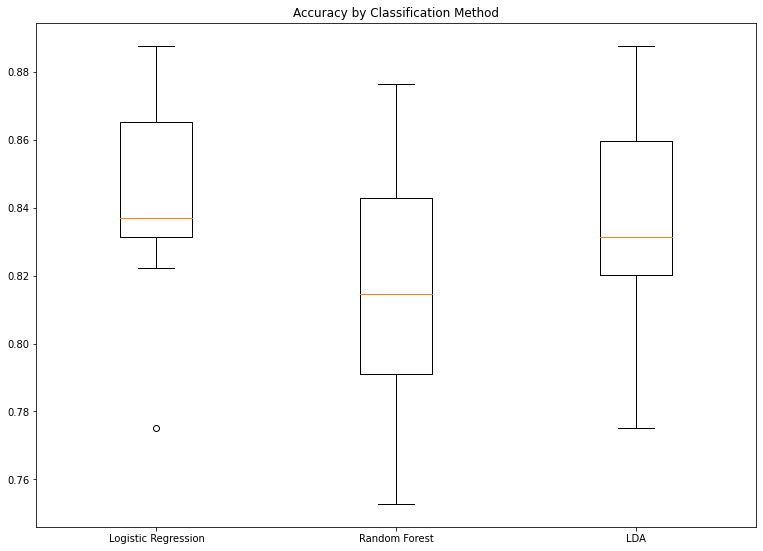

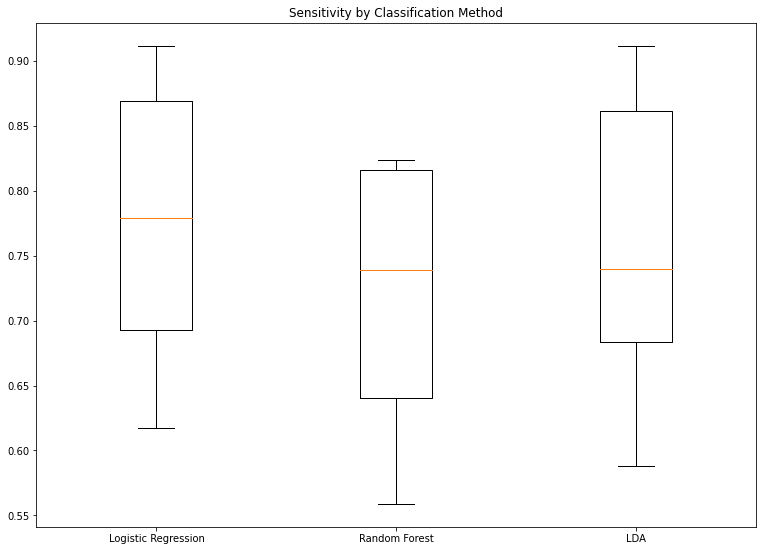

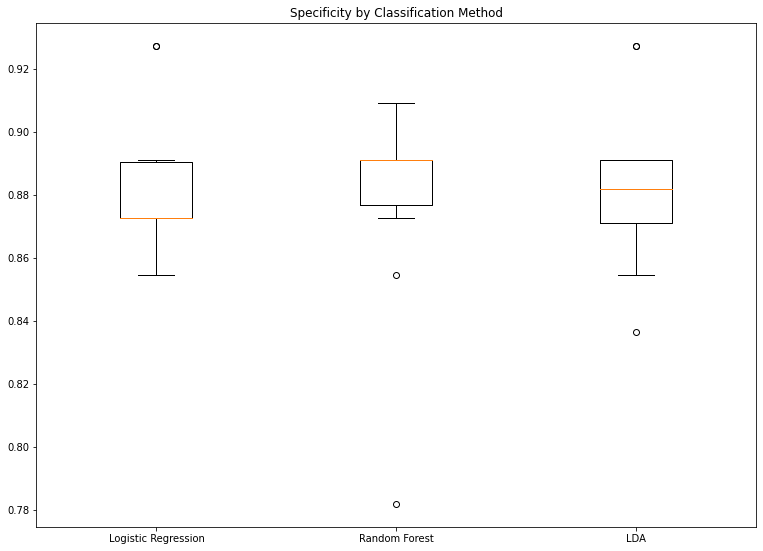

In [76]:
def compare_metrics(cv_scores, metrics, models):
    for metric in metrics:
        fig = plt.figure(figsize =(10, 7))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_title(f'{metric.title()} by Classification Method')
        ax.boxplot([score[f'test_{metric.lower()}'] for score in cv_scores])
        ax.set_xticklabels(models)
        plt.show()

cv_scores=[LRcv, RFcv, LDAcv]
models = ['Logistic Regression', 'Random Forest', 'LDA']


compare_metrics(cv_scores=cv_scores, metrics=scoring, models=models)

While all three models perform quite similarly accross all three metrics, I'm going to go with logistic regression for my final model. It had the highest accuracy and sensitivity on average and hit a max specficity of over 92%.

In [77]:
LRpipeline.fit(X, y)
predictions = LRpipeline.predict(test)

In [78]:
my_submission = pd.DataFrame({'PassengerId': id_test, 'Survived': predictions})
my_submission.to_csv('submission.csv', index = False)